In [1]:

# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LinearRegression as LM
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

In [2]:
dat= pd.read_csv("data/cleanind.csv")
dat.dtypes

health                            float64
VETERAN3                          float64
SEXVAR                              int64
_URBSTAT                          float64
lgbtq                               int64
dis                                 int64
_AGE_G                            float64
_EDUCAG                           float64
jobhaver                            int64
INCOME2                           float64
PERSDOC2                          float64
CHECKUP1                          float64
LASTDEN4                          float64
MEDCOST                           float64
HLTHPLN1                          float64
_SMOKER3                          float64
_DRNKWK1                          float64
EXERANY2                          float64
_LTASTH1                          float64
ADDEPEV3                          float64
aces                              float64
state                              object
avgqoc                            float64
married                           

In [3]:
dat['dis'].value_counts()

0    292014
1    109944
Name: dis, dtype: int64

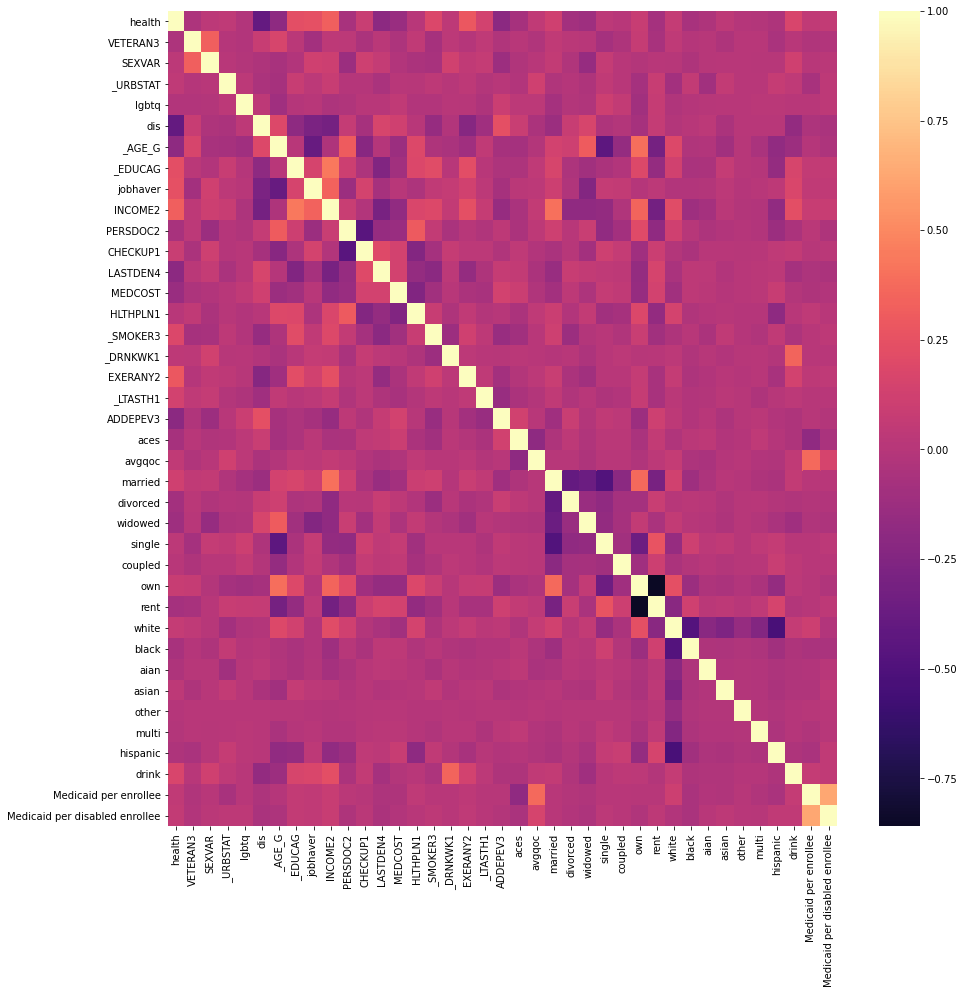

In [4]:
M = dat.select_dtypes(include=["int64", "float64"]).corr()

#plotting the float variables' correlations found above as a heat map
plt.figure(figsize = (15,15))
sns.heatmap(M, center=0,cmap="magma")
plt.show()

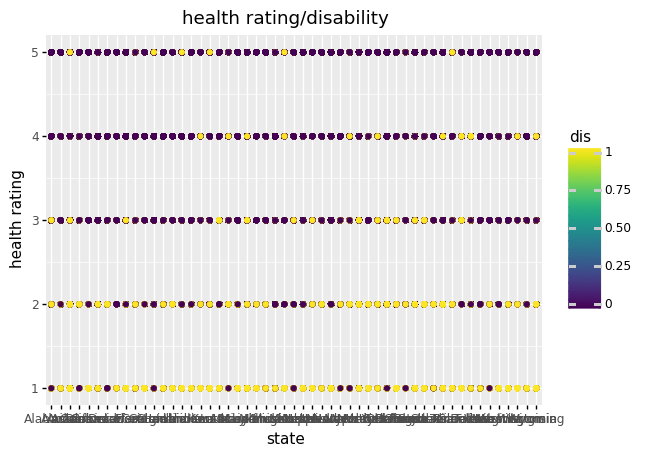

<ggplot: (142674807034)>

In [5]:
(
    ggplot(dat,aes(x = "state",y='health', groupby ='dis')) +
    geom_point(aes(color = "dis"))
      + labs(title = "health rating/disability",
          x= "state",
          y= "health rating")
)

In [6]:
dat.filter(['dis','health']).groupby(['dis']).mean(['health'])

,health
dis,
0,3.816017
1,2.875628


In [7]:
dat.filter(['dis','_AGE_G']).groupby(['_AGE_G']).sum(['dis'])

,dis
_AGE_G,
1.0,4700
2.0,7221
3.0,8678
4.0,12965
5.0,21848
6.0,54532


In [8]:
dat.filter(['health','_AGE_G']).groupby(['_AGE_G']).mean(['health'])

,health
_AGE_G,
1.0,3.915086
2.0,3.839375
3.0,3.754202
4.0,3.624562
5.0,3.474012
6.0,3.351216


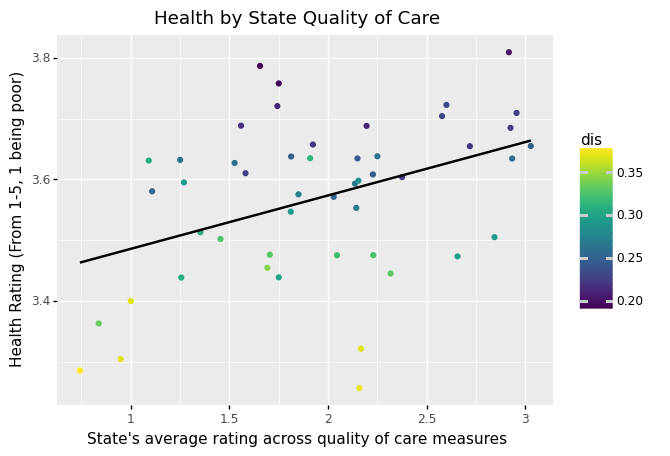

<ggplot: (134545453849)>

In [32]:
#plotting quality of care
stategrp = (dat
       .groupby(["state"])
       .mean(["health",'avgqoc','Medicaid per enrollee','Medicaid per disabled enrollee'])
       .reset_index()
      )

(
    ggplot(stategrp,aes(x = "avgqoc",y='health', groupby ='dis')) +
    geom_point(aes(color = "dis"))
      + labs(title = "Health by State Quality of Care",
          x= "State's average rating across quality of care measures",
          y= "Health Rating (From 1-5, 1 being poor)")
)

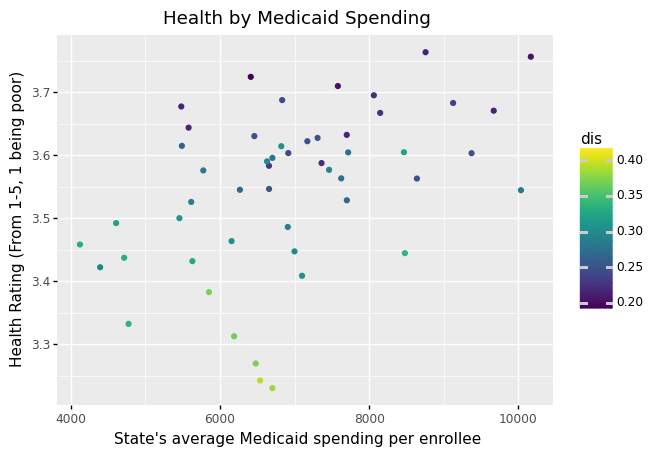

<ggplot: (142687379258)>

In [10]:
(
    ggplot(stategrp,aes(x = "Medicaid per enrollee",y='health', groupby ='dis')) +
    geom_point(aes(color = "dis"))
      + labs(title = "Health by Medicaid Spending",
          x= "State's average Medicaid spending per enrollee",
          y= "Health Rating (From 1-5, 1 being poor)")
)

In [8]:
dat = dat.dropna()
dat.dis.value_counts()


0    205024
1     75405
Name: dis, dtype: int64

In [9]:

#splitting data after processing 
y = dat[['health']]
X = dat.drop(columns=['health','state','_DRNKWK1','_URBSTAT','rent','own','other'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .8,random_state=202011)

In [10]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

search_space = [
    
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]



search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



search.fit(train_X,train_y.health)


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [BaggingRegressor()]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_mean_squared_error')

In [11]:
search.best_score_

-0.7764565039328142

In [12]:
search.best_params_

{'model': LinearRegression()}

In [13]:
rf_mod = search.best_estimator_

In [16]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)



# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)



In [40]:
vi_dat

,variable,vi,std,low,high
0,dis,9.578319e-02,1.356253e-03,9.307068e-02,9.849569e-02
1,EXERANY2,3.488637e-02,7.592837e-04,3.336781e-02,3.640494e-02
2,_AGE_G,2.023588e-02,6.493525e-04,1.893718e-02,2.153459e-02
3,INCOME2,1.917007e-02,8.069327e-04,1.755620e-02,2.078393e-02
4,ADDEPEV3,1.756611e-02,6.290554e-04,1.630800e-02,1.882422e-02
5,_LTASTH1,1.194827e-02,5.240398e-04,1.090019e-02,1.299635e-02
6,MEDCOST,1.104086e-02,5.258265e-04,9.989207e-03,1.209251e-02
7,_SMOKER3,8.916290e-03,5.304481e-04,7.855394e-03,9.977187e-03
8,LASTDEN4,8.148136e-03,4.956439e-04,7.156849e-03,9.139424e-03
9,drink,7.520084e-03,3.705995e-04,6.778885e-03,8.261283e-03


In [51]:
# Plot
pic3 = (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_minimal() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(title = "Figure 3: Variable Importance for all Respondents", y="Reduction in AUC ROC",x="")
)

pic3.save(filename = 'image/fig3.png', height=5, width=4.5, units = 'in', dpi=1000)

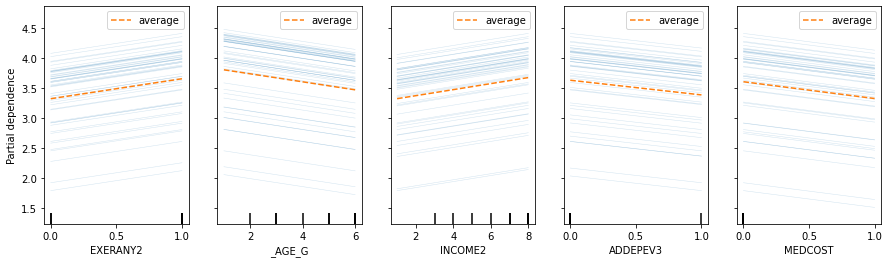

In [19]:
features = ['EXERANY2','_AGE_G','INCOME2','ADDEPEV3','MEDCOST']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    rf_mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)

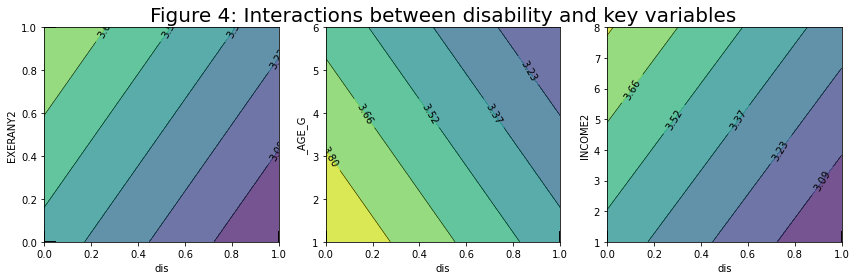

In [60]:
# Feed in the ineraction as a nested list
interacted_features = [['dis','EXERANY2'],['dis','_AGE_G'],['dis','INCOME2']] 

# Then business as usual when plotting
fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Figure 4: Interactions between disability and key variables',  fontsize=20)
display = plot_partial_dependence(
    rf_mod, train_X, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=20,ax=ax
)
fig.tight_layout()

#fig.set_size_inches(6.5, 3)
fig.savefig('image/fig4.png', dpi=1000)

In [21]:
disabled = dat[dat['dis']==1]
abled = dat[dat['dis']==0]

In [22]:
#splitting data after processing 
y1 = disabled[['health']]
X1 = disabled.drop(columns=['health','state','_DRNKWK1','dis','_URBSTAT','rent','own','other'])
train_X1, test_X1, train_y1, test_y1 = train_test_split(X1,y1,test_size = .2,random_state=202011)


search1 = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



search1.fit(train_X1,train_y1.health)


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [BaggingRegressor()]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_mean_squared_error')

In [23]:
search1.best_score_

-0.9660884079103347

In [24]:
search1.best_params_

{'model': LinearRegression()}

In [25]:
rf_mod1 = search1.best_estimator_

vi1 = permutation_importance(rf_mod1,train_X1,train_y1,n_repeats=25)



# Organize as a data frame 
vi_dat1 = pd.DataFrame(dict(variable=train_X1.columns,
                           vi1 = vi1['importances_mean'],
                           std1 = vi1['importances_std']))

# Generate intervals
vi_dat1['low'] = vi_dat1['vi1'] - 2*vi_dat1['std1']
vi_dat1['high'] = vi_dat1['vi1'] + 2*vi_dat1['std1']

# But in order from most to least important
vi_dat1 = vi_dat1.sort_values(by="vi1",ascending=False).reset_index(drop=True)






In [47]:
vi_dat1

,variable,vi1,std1,low,high
0,EXERANY2,0.065066,0.001092,0.062883,0.067250
1,ADDEPEV3,0.028941,0.000863,0.027215,0.030667
2,INCOME2,0.028061,0.000945,0.026170,0.029951
3,jobhaver,0.021899,0.000658,0.020583,0.023214
4,_AGE_G,0.019663,0.000658,0.018347,0.020979
5,_LTASTH1,0.017207,0.000617,0.015972,0.018442
6,MEDCOST,0.015253,0.000667,0.013918,0.016587
7,drink,0.011969,0.000615,0.010740,0.013198
8,LASTDEN4,0.009500,0.000395,0.008711,0.010290
9,_SMOKER3,0.008262,0.000383,0.007495,0.009029


In [58]:
# Plot
pic6 = ( 
    ggplot(vi_dat1,
          aes(x="variable",y="vi1")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_minimal() +
    scale_x_discrete(limits=vi_dat1.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

pic6.save(filename = 'image/fig6.png', height=5, width=4.5, units = 'in', dpi=1000)

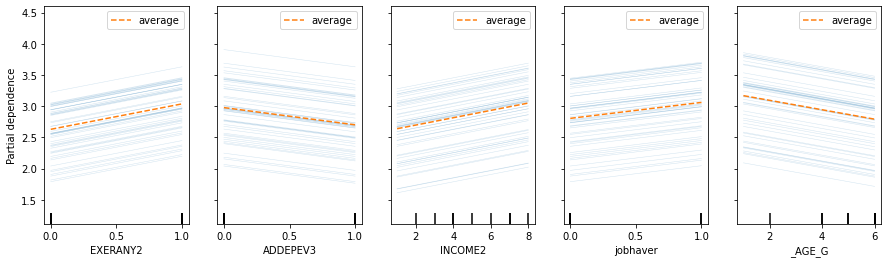

In [37]:
features = ['EXERANY2','ADDEPEV3','INCOME2','jobhaver','_AGE_G']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    rf_mod1,
    train_X1,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)

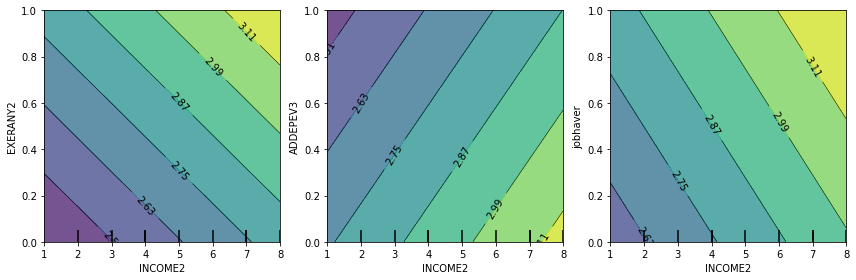

In [49]:
# Feed in the ineraction as a nested list
interacted_features = [['INCOME2','EXERANY2'],['INCOME2','ADDEPEV3'],['INCOME2','jobhaver']] 

# Then business as usual when plotting
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod1, train_X1, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=20,ax=ax
)
fig.tight_layout()

In [27]:
#splitting data after processing 
y2 = abled[['health']]
X2 = abled.drop(columns=['health','state','_DRNKWK1','dis','_URBSTAT','rent','own','other'])
train_X2, test_X2, train_y2, test_y2 = train_test_split(X2,y2,test_size = .7,random_state=202011)


search2 = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



search2.fit(train_X2,train_y2.health)


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [BaggingRegressor()]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_mean_squared_error')

In [28]:
search2.best_score_

-0.6939312315598907

In [29]:
search2.best_params_

{'model': LinearRegression()}

In [30]:
rf_mod2 = search2.best_estimator_

vi2 = permutation_importance(rf_mod2,train_X2,train_y2,n_repeats=25)



# Organize as a data frame 
vi_dat2 = pd.DataFrame(dict(variable=train_X2.columns,
                           vi2 = vi2['importances_mean'],
                           std2 = vi2['importances_std']))

# Generate intervals
vi_dat2['low'] = vi_dat2['vi2'] - 2*vi_dat2['std2']
vi_dat2['high'] = vi_dat2['vi2'] + 2*vi_dat2['std2']

# But in order from most to least important
vi_dat2 = vi_dat2.sort_values(by="vi2",ascending=False).reset_index(drop=True)




In [59]:


# Plot
pic5 = (
    ggplot(vi_dat2,
          aes(x="variable",y="vi2")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_minimal() +
    scale_x_discrete(limits=vi_dat2.variable.tolist()) +
    coord_flip() +
    labs(title = "Figure 5: Variable Importance for People Reporting No Disability",y="Reduction in AUC ROC",x="")
)

pic5.save(filename = 'image/fig5.png', height=5, width=4.5, units = 'in', dpi=1000)

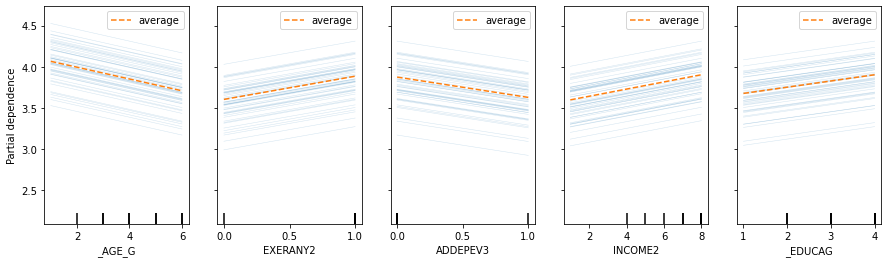

In [39]:
features = ['_AGE_G','EXERANY2','ADDEPEV3','INCOME2','_EDUCAG']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    rf_mod2,
    train_X2,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)

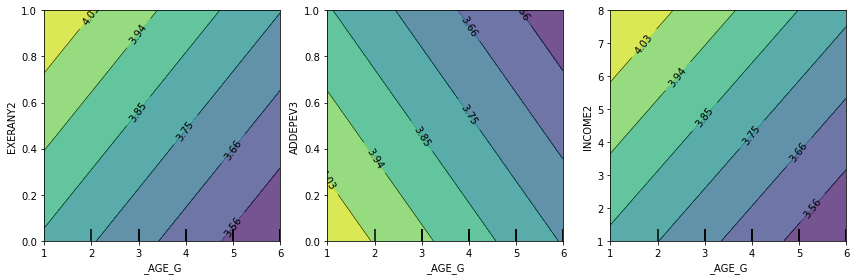

In [44]:
# Feed in the ineraction as a nested list
interacted_features = [['_AGE_G','EXERANY2'],['_AGE_G','ADDEPEV3'],['_AGE_G','INCOME2']] 

# Then business as usual when plotting
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod2, train_X2, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=20,ax=ax
)
fig.tight_layout()

